In [12]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from thermo_models.RaoultsLawModel import *
from distillation.DistillationModel import DistillationModel
from utils.AntoineEquation import * 
from IPython.display import clear_output
from tqdm import tqdm
from distillation.DistillationTernary import *
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive, Button, VBox, HBox, Output
from IPython.display import clear_output
from thermo_models.MargulesModel import *
from thermo_models.WilsonModel import *

warnings.simplefilter("ignore", RuntimeWarning)

A_ = np.array([[0, -316.699, 350.100], [-384.657, 0, 307.000],[290.200, 143.00, 0]])
P_sys = 1

#Acetaldehyde
Acet_A = 3.68639
Acet_B = 822.894
Acet_C = -69.899
#Methanol
Me_A = 5.31301
Me_B = 1676.569
Me_C = -21.728
#Water
H2O_A = 3.55959
H2O_B = 643.748
H2O_C = -198.043

#Antoine Equations 
Acet_antoine = AE.AntoineEquationBase10(Acet_A, Acet_B, Acet_C)
H2O_antoine = AE.AntoineEquationBase10(H2O_A, H2O_B, H2O_C)
Methanol_antoine = AE.AntoineEquationBase10(Me_A, Me_B, Me_C)

vle_model = MargulesModelTernary(3,P_sys,A_,[Acet_antoine, Methanol_antoine, H2O_antoine])

xF = np.array([0.3, 0.3, 0.4])
xD = np.array([0.5030, 0.4960, 0.0010])
xB = np.array([1e-10, 0.0103,0.9897])
distillation_model = DistillationModelTernary(vle_model, xF = xF, xD = xD, xB = xB, reflux = 0)

In [17]:
def eqns(uvec, l):
    res = np.empty(4)
    gammas = distillation_model.thermo_model.get_activity_coefficient(uvec[:-1], uvec[-1])

    for i in range(3):
        Psat = distillation_model.thermo_model.get_Psat_i(i, uvec[-1])
        P = distillation_model.thermo_model.get_Psys()
        res[i] = ((Psat*gammas[i]*uvec[i])/P)-((l*uvec[i])/(l+1))-(xD[i]/(l+1))
    res[3] = np.sum(uvec[:-1]) - 1

    return res

def get_dFidl(uvec, l):
    res = np.empty(4)
    for i in range(3):
        res[i] = (uvec[i]/(l-1)**2) + (xD[i]/(l+1)**2)
    res[3] = 0
    return res

def jac_eqns(uvec, l):
    gammas = distillation_model.thermo_model.get_activity_coefficient(uvec[:-1], uvec[-1])
    gamma_ders = distillation_model.thermo_model.get_gamma_ders(uvec, l)
    res = np.empty((4,4))
    P = distillation_model.thermo_model.get_Psys()

    for i in range(3):
        Psat = distillation_model.thermo_model.get_Psat_i(i, uvec[-1])
        dPsatdT = distillation_model.thermo_model.get_dPsatdT_i(i, uvec[-1])
        for j in range(3):
            if i == j:
                res[i,j] = ((Psat/P)*(gammas[i] + uvec[i]*gamma_ders[i,j])) - (l/l-1)
            else:
                res[i,j] = ((Psat*uvec[i])/P)*gamma_ders[i,j]
            res[i,3] = (uvec[i]/P)*(Psat*gamma_ders[i,3]+gammas[i]*dPsatdT)
    res[3,:] = [1,1,1,0]
    return res

def eqns_der(xvec, u1, u2, u3, u4, l):
    res = np.empty(5)

    jac = jac_eqns(np.array([u1,u2,u3,u4]), l)
    dFidl = get_dFidl(np.array([u1,u2,u3,u4]), l)

    for i in range(4):
        res[i] = sum([jac[i,j]*xvec[j] for j in range(4)])
        res[i] += dFidl[i]*xvec[4]

    res[4] = sum([xvec[i]**2 for i in range(5)]) - 1

    return res
    
def eqns_aug(uvec, tau, ds, u0):
    l         = uvec[-1]
    res       = np.zeros_like(uvec)
    res[0:-1] = eqns(uvec[:-1], l)
    res[-1] = sum([(uvec[i] - u0[i])*tau[i] for i in range(5)]) - ds

    return res

def jac_eqns_aug(uvec, der, ds, u0):
    l = uvec[-1]
    res = np.empty((5,5))

    jac = jac_eqns(uvec[:-1], l)
    dFidl = get_dFidl(uvec[:-1], l)

    res[0:4, 0:4] = jac
    res[0:4, 4] = dFidl
    res[4, :] = der
        
    return res

ds = 0.001
num_steps = 50000
lam_m1 = 0.001
old_sol_m1 = fsolve(eqns, x0=np.array([0.23, 0.75, 0.02, 300]), fprime=jac_eqns, args=(lam_m1,))
print(old_sol_m1)
lam_0 = lam_m1 + ds
old_sol = fsolve(eqns, x0=old_sol_m1, fprime=jac_eqns, args=(lam_0,))
print(old_sol)

x1_sol = np.empty((num_steps))
x2_sol = np.empty((num_steps))
x3_sol = np.empty((num_steps))
T_sol = np.empty((num_steps))
l_sol  = np.empty((num_steps))

for i in range(num_steps):
    if i % 1000 == 0:
        print('x1 x2 = ' + str(old_sol) + ', l = ' + str(lam_0))

    # Solve for tangent vector
    # del_s       = math.sqrt(np.linalg.norm(lam_0 - lam_m1)**2)
    del_s = ds
    # Approximation from eqn 8 of Laing
    guess       = np.array([ (old_sol[0] - old_sol_m1[0])/del_s, (old_sol[1] - old_sol_m1[1])/del_s, (old_sol[2] - old_sol_m1[2])/del_s, (old_sol[3] - old_sol_m1[3])/del_s, (lam_0 - lam_m1)/del_s  ])
    tau = fsolve(eqns_der, guess, args = (old_sol[0], old_sol[1], old_sol[2], old_sol[3], lam_0))
    
    prev_sol    = np.array([old_sol[0], old_sol[1], old_sol[2], old_sol[3], lam_0])
    new_sol     = fsolve(eqns_aug, x0 = prev_sol + ds*tau, fprime=jac_eqns_aug, args = (tau, ds, prev_sol))
    
    # Edit the variables that hold the two prior solutions
    lam_m1, lam_0 = lam_0, new_sol[-1]
    old_sol_m1 = np.copy(old_sol)
    old_sol    = np.copy(new_sol[:-1])

    # Add solutions to a list
    x1_sol[i] = old_sol[0]
    x2_sol[i] = old_sol[1]
    x3_sol[i] = old_sol[2]
    T_sol[i] = old_sol[3]
    l_sol[i] = lam_0

x3r_x1 = x1_sol
x3r_x2 = x2_sol
x3r_x3 = x3_sol
x3r_T = T_sol
x3r_l = l_sol

[2.68264419e-01 7.20799144e-01 1.09364370e-02 3.29560437e+02]
[2.68104729e-01 7.20854988e-01 1.10402834e-02 3.29568509e+02]
x1 x2 = [2.68104729e-01 7.20854988e-01 1.10402834e-02 3.29568509e+02], l = 0.002
x1 x2 = [2.50629743e-01 7.13238367e-01 3.61318892e-02 3.30569742e+02], l = 0.07828730286556561
x1 x2 = [2.36018421e-01 6.90612310e-01 7.33692693e-02 3.31569910e+02], l = 0.10096831432449588
x1 x2 = [2.22340553e-01 6.64989239e-01 1.12670208e-01 3.32569770e+02], l = 0.1134284100342492
x1 x2 = [2.09199019e-01 6.38241735e-01 1.52559246e-01 3.33569484e+02], l = 0.12320236155304823
x1 x2 = [1.96463056e-01 6.10711941e-01 1.92825003e-01 3.34569100e+02], l = 0.13190238887421665
x1 x2 = [1.84062698e-01 5.82478162e-01 2.33459140e-01 3.35568640e+02], l = 0.14004760757812373
x1 x2 = [1.71955372e-01 5.53563436e-01 2.74481192e-01 3.36568113e+02], l = 0.1478560377160729
x1 x2 = [1.60118881e-01 5.23995647e-01 3.15885473e-01 3.37567527e+02], l = 0.15544694170021287
x1 x2 = [1.48551116e-01 4.93838193e-0

In [23]:
def s(r):
    q = 1
    return ((r+q)*((xF[0]-xB[0])/(xD[0]-xF[0]))) + q - 1

def eqns(uvec, l):
    res = np.empty(4)
    gammas = distillation_model.thermo_model.get_activity_coefficient(uvec[:-1], uvec[-1])

    for i in range(3):
        Psat = distillation_model.thermo_model.get_Psat_i(i, uvec[-1])
        P = distillation_model.thermo_model.get_Psys()
        res[i] = ((Psat*gammas[i]*uvec[i])/P)-(((s(l)+1)*uvec[i])/s(l))+(xB[i]/s(l))
    res[3] = np.sum(uvec[:-1]) - 1

    return res

def get_dFidl(uvec, l):
    res = np.empty(4)
    for i in range(3):
        res[i] = (uvec[i]-xB[i])/s(l)**2
    res[3] = 0
    return res

def jac_eqns(uvec, l):
    gammas = distillation_model.thermo_model.get_activity_coefficient(uvec[:-1], uvec[-1])
    gamma_ders = distillation_model.thermo_model.get_gamma_ders(uvec, l)
    res = np.empty((4,4))
    P = distillation_model.thermo_model.get_Psys()

    for i in range(3):
        Psat = distillation_model.thermo_model.get_Psat_i(i, uvec[-1])
        dPsatdT = distillation_model.thermo_model.get_dPsatdT_i(i, uvec[-1])
        for j in range(3):
            if i == j:
                res[i,j] = ((Psat/P)*(gammas[i] + uvec[i]*gamma_ders[i,j])) - ((s(l)+1)/s(l))
            else:
                res[i,j] = ((Psat*uvec[i])/P)*gamma_ders[i,j]
            res[i,3] = (uvec[i]/P)*(Psat*gamma_ders[i,3]+gammas[i]*dPsatdT)
    res[3,:] = [1,1,1,0]
    return res

def eqns_der(xvec, u1, u2, u3, u4, l):
    res = np.empty(5)

    jac = jac_eqns(np.array([u1,u2,u3,u4]), l)
    dFidl = get_dFidl(np.array([u1,u2,u3,u4]), l)

    for i in range(4):
        res[i] = sum([jac[i,j]*xvec[j] for j in range(4)])
        res[i] += dFidl[i]*xvec[4]

    res[4] = sum([xvec[i]**2 for i in range(5)]) - 1

    return res
    
def eqns_aug(uvec, tau, ds, u0):
    l         = uvec[-1]
    res       = np.zeros_like(uvec)
    res[0:-1] = eqns(uvec[:-1], l)
    res[-1] = sum([(uvec[i] - u0[i])*tau[i] for i in range(5)]) - ds

    return res

def jac_eqns_aug(uvec, der, ds, u0):
    l = uvec[-1]
    res = np.empty((5,5))

    jac = jac_eqns(uvec[:-1], l)
    dFidl = get_dFidl(uvec[:-1], l)

    res[0:4, 0:4] = jac
    res[0:4, 4] = dFidl
    res[4, :] = der
        
    return res

ds = 0.001
num_steps = 50000
lam_m1 = 0.001
old_sol_m1 = fsolve(eqns, x0=np.array([0, 1, 0, 300]), fprime=jac_eqns, args=(lam_m1,))
print(old_sol_m1)
lam_0 = lam_m1 + ds
old_sol = fsolve(eqns, x0=old_sol_m1, fprime=jac_eqns, args=(lam_0,))
print(old_sol)

x1_sol = np.empty((num_steps))
x2_sol = np.empty((num_steps))
x3_sol = np.empty((num_steps))
T_sol = np.empty((num_steps))
l_sol  = np.empty((num_steps))

for i in range(num_steps):
    if i % 1000 == 0:
        print('x1 x2 = ' + str(old_sol) + ', l = ' + str(lam_0))

    # Solve for tangent vector
    # del_s       = math.sqrt(np.linalg.norm(lam_0 - lam_m1)**2)
    del_s = ds
    # Approximation from eqn 8 of Laing
    guess       = np.array([ (old_sol[0] - old_sol_m1[0])/del_s, (old_sol[1] - old_sol_m1[1])/del_s, (old_sol[2] - old_sol_m1[2])/del_s, (old_sol[3] - old_sol_m1[3])/del_s, (lam_0 - lam_m1)/del_s  ])
    tau = fsolve(eqns_der, guess, args = (old_sol[0], old_sol[1], old_sol[2], old_sol[3], lam_0))
    
    prev_sol    = np.array([old_sol[0], old_sol[1], old_sol[2], old_sol[3], lam_0])
    new_sol     = fsolve(eqns_aug, x0 = prev_sol + ds*tau, fprime=jac_eqns_aug, args = (tau, ds, prev_sol))
    
    # Edit the variables that hold the two prior solutions
    lam_m1, lam_0 = lam_0, new_sol[-1]
    old_sol_m1 = np.copy(old_sol)
    old_sol    = np.copy(new_sol[:-1])

    # Add solutions to a list
    x1_sol[i] = old_sol[0]
    x2_sol[i] = old_sol[1]
    x3_sol[i] = old_sol[2]
    T_sol[i] = old_sol[3]
    l_sol[i] = lam_0

x2s_x1 = x1_sol
x2s_x2 = x2_sol
x2s_x3 = x3_sol
x2s_T = T_sol
x2s_l = l_sol

[-3.82028346e-11  5.32303499e-01  4.67696501e-01  3.48658204e+02]
[-3.15615117e-11  5.32571336e-01  4.67428664e-01  3.48651409e+02]
x1 x2 = [-3.15615117e-11  5.32571336e-01  4.67428664e-01  3.48651409e+02], l = 0.002
x1 x2 = [-3.0367155e-11  5.7182269e-01  4.2817731e-01  3.4766280e+02], l = 0.16142791258826877
x1 x2 = [-2.90419030e-11  6.11301221e-01  3.88698779e-01  3.46678751e+02], l = 0.3527174411167806
x1 x2 = [-2.75665097e-11  6.50721454e-01  3.49278546e-01  3.45701928e+02], l = 0.5850050710647351
x1 x2 = [-2.59231045e-11  6.89780343e-01  3.10219657e-01  3.44737119e+02], l = 0.8712031107781891
x1 x2 = [-2.41011009e-11  7.28071029e-01  2.71928971e-01  3.43793183e+02], l = 1.2291081153609387
x1 x2 = [-2.21110671e-11  7.64934154e-01  2.35065846e-01  3.42886370e+02], l = 1.6811593694231692
x1 x2 = [-2.00084490e-11  7.99295317e-01  2.00704683e-01  3.42043762e+02], l = 2.2493660460034293
x1 x2 = [-1.79091923e-11  8.29761409e-01  1.70238591e-01  3.41300051e+02], l = 2.9425588704791146
x1

In [24]:
def s(r):
    q = 1
    return ((r+q)*((xF[0]-xB[0])/(xD[0]-xF[0]))) + q - 1

def eqns(uvec, l):
    res = np.empty(4)
    gammas = distillation_model.thermo_model.get_activity_coefficient(uvec[:-1], uvec[-1])

    for i in range(3):
        Psat = distillation_model.thermo_model.get_Psat_i(i, uvec[-1])
        P = distillation_model.thermo_model.get_Psys()
        res[i] = ((Psat*gammas[i]*uvec[i])/P)-(((s(l)+1)*uvec[i])/s(l))+(xB[i]/s(l))
    res[3] = np.sum(uvec[:-1]) - 1

    return res

def get_dFidl(uvec, l):
    res = np.empty(4)
    for i in range(3):
        res[i] = (uvec[i]-xB[i])/s(l)**2
    res[3] = 0
    return res

def jac_eqns(uvec, l):
    gammas = distillation_model.thermo_model.get_activity_coefficient(uvec[:-1], uvec[-1])
    gamma_ders = distillation_model.thermo_model.get_gamma_ders(uvec, l)
    res = np.empty((4,4))
    P = distillation_model.thermo_model.get_Psys()

    for i in range(3):
        Psat = distillation_model.thermo_model.get_Psat_i(i, uvec[-1])
        dPsatdT = distillation_model.thermo_model.get_dPsatdT_i(i, uvec[-1])
        for j in range(3):
            if i == j:
                res[i,j] = ((Psat/P)*(gammas[i] + uvec[i]*gamma_ders[i,j])) - ((s(l)+1)/s(l))
            else:
                res[i,j] = ((Psat*uvec[i])/P)*gamma_ders[i,j]
            res[i,3] = (uvec[i]/P)*(Psat*gamma_ders[i,3]+gammas[i]*dPsatdT)
    res[3,:] = [1,1,1,0]
    return res

def eqns_der(xvec, u1, u2, u3, u4, l):
    res = np.empty(5)

    jac = jac_eqns(np.array([u1,u2,u3,u4]), l)
    dFidl = get_dFidl(np.array([u1,u2,u3,u4]), l)

    for i in range(4):
        res[i] = sum([jac[i,j]*xvec[j] for j in range(4)])
        res[i] += dFidl[i]*xvec[4]

    res[4] = sum([xvec[i]**2 for i in range(5)]) - 1

    return res
    
def eqns_aug(uvec, tau, ds, u0):
    l         = uvec[-1]
    res       = np.zeros_like(uvec)
    res[0:-1] = eqns(uvec[:-1], l)
    res[-1] = sum([(uvec[i] - u0[i])*tau[i] for i in range(5)]) - ds

    return res

def jac_eqns_aug(uvec, der, ds, u0):
    l = uvec[-1]
    res = np.empty((5,5))

    jac = jac_eqns(uvec[:-1], l)
    dFidl = get_dFidl(uvec[:-1], l)

    res[0:4, 0:4] = jac
    res[0:4, 4] = dFidl
    res[4, :] = der
        
    return res

ds = 0.001
num_steps = 50000
lam_m1 = 0.001
old_sol_m1 = fsolve(eqns, x0=np.array([1, 0, 0, 300]), fprime=jac_eqns, args=(lam_m1,))
print(old_sol_m1)
lam_0 = lam_m1 + ds
old_sol = fsolve(eqns, x0=old_sol_m1, fprime=jac_eqns, args=(lam_0,))
print(old_sol)

x1_sol = np.empty((num_steps))
x2_sol = np.empty((num_steps))
x3_sol = np.empty((num_steps))
T_sol = np.empty((num_steps))
l_sol  = np.empty((num_steps))

for i in range(num_steps):
    if i % 1000 == 0:
        print('x1 x2 = ' + str(old_sol) + ', l = ' + str(lam_0))

    # Solve for tangent vector
    # del_s       = math.sqrt(np.linalg.norm(lam_0 - lam_m1)**2)
    del_s = ds
    # Approximation from eqn 8 of Laing
    guess       = np.array([ (old_sol[0] - old_sol_m1[0])/del_s, (old_sol[1] - old_sol_m1[1])/del_s, (old_sol[2] - old_sol_m1[2])/del_s, (old_sol[3] - old_sol_m1[3])/del_s, (lam_0 - lam_m1)/del_s  ])
    tau = fsolve(eqns_der, guess, args = (old_sol[0], old_sol[1], old_sol[2], old_sol[3], lam_0))
    
    prev_sol    = np.array([old_sol[0], old_sol[1], old_sol[2], old_sol[3], lam_0])
    new_sol     = fsolve(eqns_aug, x0 = prev_sol + ds*tau, fprime=jac_eqns_aug, args = (tau, ds, prev_sol))
    
    # Edit the variables that hold the two prior solutions
    lam_m1, lam_0 = lam_0, new_sol[-1]
    old_sol_m1 = np.copy(old_sol)
    old_sol    = np.copy(new_sol[:-1])

    # Add solutions to a list
    x1_sol[i] = old_sol[0]
    x2_sol[i] = old_sol[1]
    x3_sol[i] = old_sol[2]
    T_sol[i] = old_sol[3]
    l_sol[i] = lam_0

x1s_x1 = x1_sol
x1s_x2 = x2_sol
x1s_x3 = x3_sol
x1s_T = T_sol
x1s_l = l_sol

[5.95386846e-01 4.43165537e-03 4.00181499e-01 3.03336651e+02]
[5.95628129e-01 4.42890929e-03 3.99942962e-01 3.03330377e+02]
x1 x2 = [5.95628129e-01 4.42890929e-03 3.99942962e-01 3.03330377e+02], l = 0.002
x1 x2 = [6.34112660e-01 3.99317427e-03 3.61894166e-01 3.02343705e+02], l = 0.17838477242001158
x1 x2 = [6.73116032e-01 3.55575226e-03 3.23328215e-01 3.01364346e+02], l = 0.3995264557078927
x1 x2 = [7.12061358e-01 3.12266455e-03 2.84815977e-01 3.00397686e+02], l = 0.6801138367437557
x1 x2 = [7.50241640e-01 2.70122957e-03 2.47057130e-01 2.99453947e+02], l = 1.0401262556040154
x1 x2 = [7.86681291e-01 2.30158071e-03 2.11017129e-01 2.98552104e+02], l = 1.503908275489055
x1 x2 = [8.20025362e-01 1.93784941e-03 1.78036789e-01 2.97722997e+02], l = 2.0928307002534576
x1 x2 = [8.48813294e-01 1.62518456e-03 1.49561522e-01 2.97002674e+02], l = 2.8102254450081796
x1 x2 = [8.72264138e-01 1.37134306e-03 1.26364519e-01 2.96412129e+02], l = 3.633604328759042
x1 x2 = [8.90690699e-01 1.17238919e-03 1.081

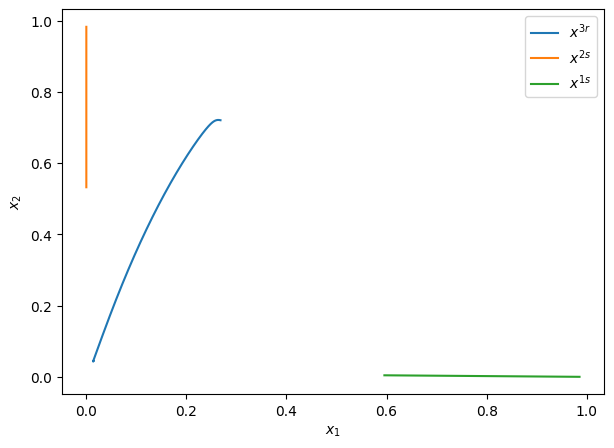

In [27]:
fig, ax = plt.subplots( figsize = (7,5))

ax.plot(x3r_x1, x3r_x2, label=r'$x^{3r}$')
ax.plot(x2s_x1, x2s_x2, label=r'$x^{2s}$')
ax.plot(x1s_x1, x1s_x2, label=r'$x^{1s}$')

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.legend()

# plt.tight_layout()

plt.show()

In [35]:
(1,2,3)+(4,)

(1, 2, 3, 4)